In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools
import igraph

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_graph, evolution_regression, evolution_linlog_regressions, 
                     savefig, x_index, gini)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Use a subset of dates to speed up the notebook. 
# THIS LINE SHOULD BE COMMENTED IN PRODUCTION!
# DATE_RANGE = pandas.date_range(DATE_RANGE[0], DATE_RANGE[-1], freq='3MS')

FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}
sub = lambda c, e: [c[x] for x in e]

In [3]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cargo: .............................................................
cpan: .............................................................
cran: .............................................................
npm: .............................................................
nuget: .............................................................
packagist: .............................................................
rubygems: .............................................................


## Graph size

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


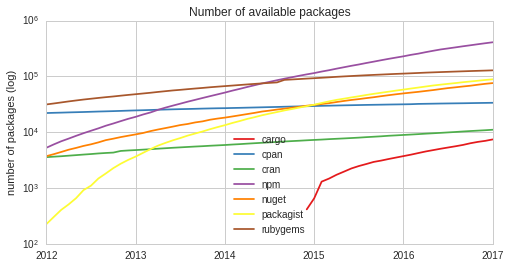

In [4]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = graph.vcount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='number of packages (log)',
    title='Number of available packages',
)

savefig(figure, 'graph_number_of_packages')

In [5]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.992577,0.998341,0.987858,0.878733,0.945816,0.929494,0.99475
lin-log,0.861659,0.991618,0.995779,0.983939,0.982103,0.903242,0.973238
log-lin,0.61026,0.646502,0.570814,0.390111,0.47421,0.43744,0.604362
log-log,0.88469,0.680449,0.670135,0.711409,0.718193,0.817622,0.713142


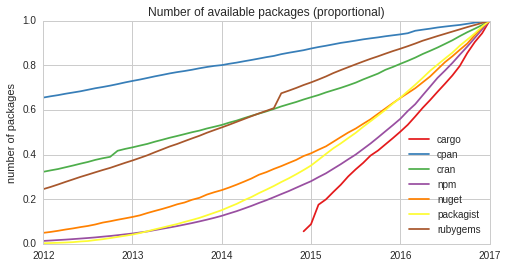

In [6]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue        
        df.loc[date, ecosystem] = graph.vcount() / graphs[ecosystem][DATE_RANGE[-1]].vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='number of packages',
    title='Number of available packages (proportional)',
)

savefig(figure, 'graph_proportion_of_packages')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


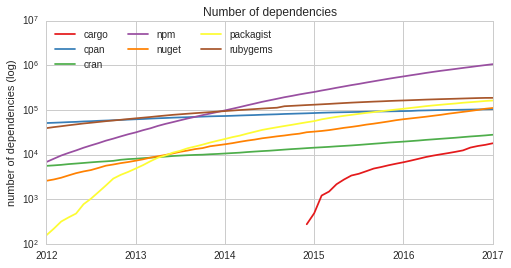

In [7]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue        
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='number of dependencies (log)',
    title='Number of dependencies',
)
ax.legend(loc='upper left', ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_number_of_dependencies')

In [8]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.968174,0.997731,0.949218,0.851819,0.885422,0.926782,0.996761
lin-log,0.852518,0.98289,0.997858,0.982219,0.988464,0.87518,0.968479
log-lin,0.515419,0.643649,0.49523,0.363323,0.40371,0.430846,0.606653
log-log,0.878857,0.699342,0.640579,0.716718,0.702121,0.827576,0.728969


## Graph density

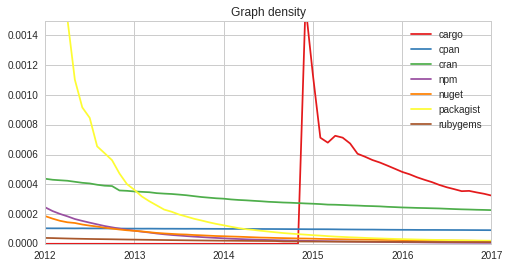

In [9]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        vs = graph.vcount()
        es = graph.ecount()
        df.loc[date, ecosystem] = (es) / (vs * (vs - 1)) if vs > 0 else 0
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='',
    title='Graph density',
    ylim=(0, 0.0015),
)

savefig(figure, 'graph_density')

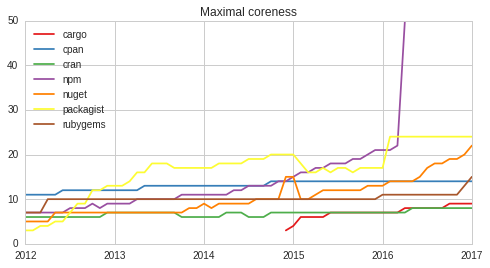

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        coreness = graph.coreness()
        df.loc[date, ecosystem] = pandas.np.max(coreness)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Maximal coreness',
)

savefig(figure, 'graph_maximal_coreness')

## Clustering coefficient and average shortest path length

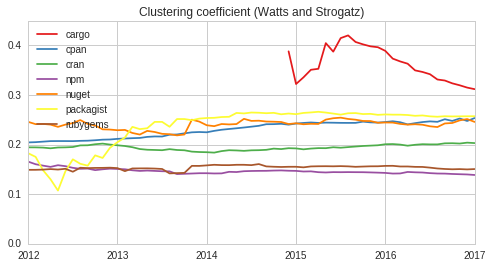

In [11]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        value = graph.transitivity_avglocal_undirected()
        # value = graph.transitivity_undirected()
        df.loc[date, ecosystem] = value
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Clustering coefficient (Watts and Strogatz)',
)
ax.set_ylim(bottom=0)

savefig(figure, 'graph_clustering_coefficient')

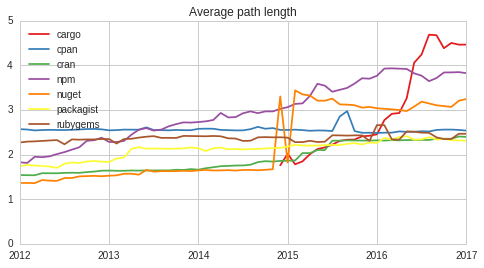

In [12]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        value = graph.average_path_length()
        df.loc[date, ecosystem] = value
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Average path length',
)
ax.set_ylim(bottom=0)

savefig(figure, 'graph_average_path_length')

**TODO** : 

https://en.wikipedia.org/wiki/Scale-free_network

https://arxiv.org/pdf/cs/0411096.pdf


## Distribution of dependencies

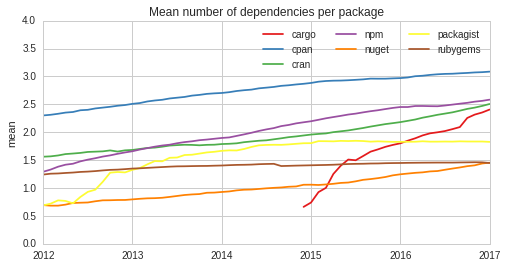

In [13]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        
        df.loc[date, ecosystem] = graph.ecount() / graph.vcount()

df.plot(ax=ax)

ax.set(
    title='Mean number of dependencies per package',
    ylabel='mean',
    ylim=(0, 4),
)

ax.legend(ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_mean_dependencies_per_package')

In [14]:
pandas.concat([df.min(), df.max(), df.iloc[-1] / df.iloc[-24], df.iloc[-1]], axis=1)

,0,1,2,2017-01-01 00:00:00
cargo,0.661836,2.405875,2.59771,2.40588
cpan,2.300404,3.085380,1.06205,3.08538
cran,1.560784,2.505645,1.27248,2.50565
npm,1.291065,2.583283,1.16247,2.58328
nuget,0.683585,1.453483,1.3789,1.45348
packagist,0.688889,1.845918,0.99282,1.82648
rubygems,1.240879,1.461659,1.02685,1.44825


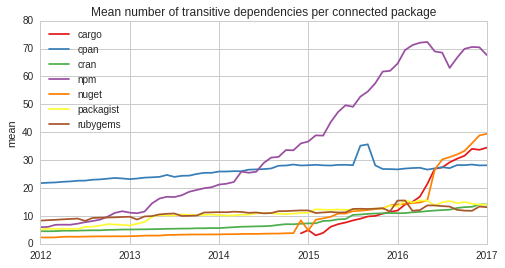

In [15]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        connected = graph.vs.select(**{'out_gt': 0})
        transitive = sum(connected['tr-out'])
        
        df.loc[date, ecosystem] = transitive / len(connected)

df.plot(ax=ax)

ax.set(
    title='Mean number of transitive dependencies per connected package',
    ylabel='mean',
)

#ax.legend(ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_mean_transitive_per_connected')

In [16]:
data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for node in graph.vs:
        if node['in'] + node['out'] == 0:
            continue

        if node['in'] > 0:
            if node['out'] > 0:
                p_type = 'both'
            else:
                p_type = 'required'
        else:
            p_type = 'dependent'
            
        data.append((
            ecosystem, 
            p_type, 
            node['in'],
            node['out'],
            node['tr-in'],
            node['tr-out']
        ))
        
data = (
    pandas.DataFrame.from_records(
        data, 
        columns=['ecosystem', 'p_type', 'in', 'out', 'tr-in', 'tr-out']
    )
    .pipe(
        pandas.melt,
        id_vars=['ecosystem', 'p_type'], 
        value_vars=['in', 'out', 'tr-in', 'tr-out'], 
        var_name='kind'
    )
)

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


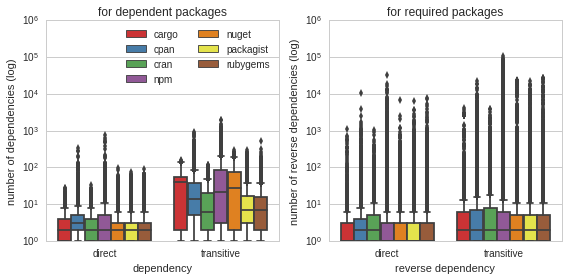

In [17]:
figure, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True)
figure.set_size_inches(FIG_SIZE)

bx_ = seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data.query('(kind == "out" or kind == "tr-out") and p_type != "required"'),
    ax=axes[0],
    order=['out', 'tr-out'],
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

axes[0].set(
    xlabel='dependency', 
    ylabel='number of dependencies (log)',
    yscale='log',
    title='for dependent packages',
)
axes[0].set_xticklabels(['direct', 'transitive'])
axes[0].legend(ncol=2)


seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data.query('(kind == "in" or kind == "tr-in") and p_type != "dependent"'),
    ax=axes[1],
    order=['in', 'tr-in'],
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

axes[1].set(
    xlabel='reverse dependency', 
    ylabel='number of reverse dependencies (log)',
    yscale='log',
    title='for required packages',
)

axes[1].set_xticklabels(['direct', 'transitive'])
axes[1].legend([])

matplotlib.pyplot.setp(axes[1].get_yticklabels(), visible=True)
matplotlib.pyplot.tight_layout()

savefig(figure, 'graph_distribution_dependencies_non_isolated')

In [18]:
(
    data
    .query('(kind == "out" or kind == "tr-out") and p_type != "required"')
    .groupby(['ecosystem', 'kind'])
    ['value']
    .describe()
    .unstack()
)

count                mean                  std              min  \
kind            out    tr-out       out     tr-out       out      tr-out  out   
ecosystem                                                                       
cargo        5272.0    5272.0  3.372724  34.476480  3.117645   34.472030  1.0   
cpan        24229.0   24229.0  4.287548  28.145033  6.369321   40.233886  1.0   
cran         7890.0    7890.0  3.386312  14.162231  2.885716   17.429169  1.0   
npm        252422.0  252422.0  4.165140  67.637472  6.437355  112.128728  1.0   
nuget       41297.0   41297.0  2.670581  39.435383  3.325654   45.511829  1.0   
packagist   60064.0   60064.0  2.688499  14.073155  3.215438   19.355898  1.0   
rubygems    77859.0   77859.0  2.387174  13.130210  2.491919   17.005556  1.0   

                  25%         50%         75%           max          
kind      tr-out  out tr-out  out tr-out  out tr-out    out  tr-out  
ecosystem                                                            
cargo        1.0  1.0    2.0  2.0   41.0  4.0   56.0   28.0   155.0  
cpan         1.0  2.0    5.0  3.0   14.0  5.0   37.0  343.0   924.0  
cran         1.0  1.0    2.0  2.0    6.0  4.0   20.0   33.0   117.0  
npm          1.0  1.0    3.0  2.0   21.0  5.0   82.0  765.0  1998.0  
nuget        1.0  1.0    2.0  2.0   27.0  3.0   76.0   98.0   296.0  
packagist    1.0  1.0    3.0  2.0    7.0  3.0   17.0   75.0   305.0  
rubygems     1.0  1.0    2.0  2.0    7.0  3.0   16.0   91.0   519.0

In [19]:
(
    data
    .query('(kind == "in" or kind == "tr-in") and p_type != "dependent"')
    .groupby(['ecosystem', 'kind'])
    ['value']
    .describe()
    .unstack()
)

count                mean                     std               \
kind            in    tr-in         in       tr-in          in        tr-in   
ecosystem                                                                     
cargo       2205.0   2205.0   8.063946   82.430839   46.947184   400.030467   
cpan        9744.0   9744.0  10.661227   69.984195  129.700930   597.576961   
cran        2517.0   2517.0  10.615018   44.394120   46.044459   226.651330   
npm        86677.0  86677.0  12.129781  196.974815  206.919076  2377.141813   
nuget      16127.0  16127.0   6.838656  100.983630   68.774332  1097.013266   
packagist  20735.0  20735.0   7.787895   40.766337   80.337347   473.954448   
rubygems   16761.0  16761.0  11.089016   60.993079  125.041931   762.056299   

           min        25%        50%        75%            max            
kind        in tr-in   in tr-in   in tr-in   in tr-in       in     tr-in  
ecosystem                                                                 
cargo      1.0   1.0  1.0   1.0  1.0   2.0  3.0   6.0   1114.0    4102.0  
cpan       1.0   1.0  1.0   1.0  2.0   2.0  4.0   7.0  10797.0   21843.0  
cran       1.0   1.0  1.0   1.0  2.0   2.0  5.0   8.0   1048.0    3816.0  
npm        1.0   1.0  1.0   1.0  1.0   2.0  3.0   6.0  32039.0  105634.0  
nuget      1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   7022.0   23173.0  
packagist  1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   6380.0   22526.0  
rubygems   1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   7671.0   27866.0

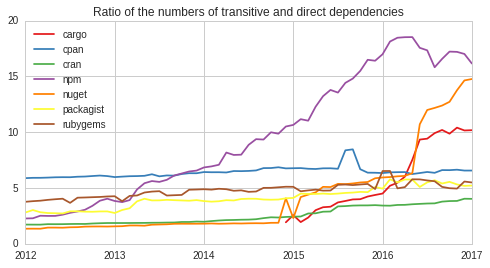

In [20]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = sum(node['tr-out'] for node in graph.vs.select(**{'tr-out_gt': 0})) / graph.ecount()
        
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio of the numbers of transitive and direct dependencies',
)

savefig(figure, 'graph_ratio_transitive_per_direct')

In [21]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,1.927007,10.407472,10.1804
cpan,5.883760,8.464031,6.56367
cran,1.716281,4.038870,4.02812
npm,2.269474,18.522114,16.1572
nuget,1.351852,14.764984,14.765
packagist,2.716883,5.778226,5.2198
rubygems,3.668201,6.525641,5.49659


/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


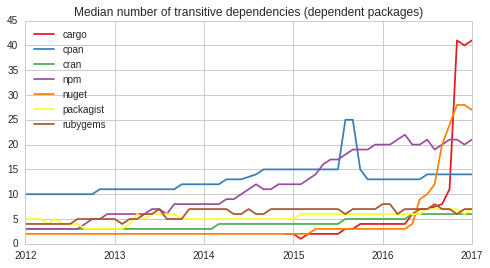

In [22]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = pandas.np.median(
            [v['tr-out'] for v in graph.vs if v['out'] > 0]
        )
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies (dependent packages)',
)

savefig(figure, 'graph_median_transitive_dependencies')

In [23]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,1.0,41.0,41
cpan,10.0,25.0,14
cran,3.0,6.0,6
npm,3.0,22.0,21
nuget,2.0,28.0,27
packagist,3.0,7.0,7
rubygems,4.0,8.0,7


In [24]:
ecosystem = 'nuget'
date_1 = DATE_RANGE[53]
date_2 = DATE_RANGE[59]

print(date_1, date_2)

nodes_1 = graphs[ecosystem][date_1].vs
nodes_2 = graphs[ecosystem][date_2].vs

df_1 = pandas.DataFrame([(n['name'], n['tr-in'], n['tr-out']) for n in nodes_1], columns=['name', 'trin1', 'trout1'])
df_2 = pandas.DataFrame([(n['name'], n['tr-in'], n['tr-out']) for n in nodes_2], columns=['name', 'trin2', 'trout2'])

(
    df_1
    .merge(df_2, on='name', how='outer')
    .query('trout2 >= 10 and trin2 >= 100')
    .assign(delta_trout=lambda d: d['trout2'] - d['trout1']) 
    .assign(delta_trin=lambda d: d['trin2'] - d['trin1']) 
    .sort_values('delta_trin', ascending=False)
)

2016-06-01 00:00:00 2016-12-01 00:00:00


,name,trin1,trout1,trin2,trout2,delta_trout,delta_trin
53780,System.Net.Http,3586.0,29.0,11459.0,42.0,13.0,7873.0
53833,System.Security.Cryptography.OpenSsl,3589.0,13.0,11462.0,23.0,10.0,7873.0
53732,NETStandard.Library,2555.0,51.0,10390.0,66.0,15.0,7835.0
53777,System.Linq.Expressions,12331.0,17.0,19703.0,17.0,0.0,7372.0
58672,Newtonsoft.Json,10692.0,27.0,14510.0,30.0,3.0,3818.0
54069,Microsoft.Extensions.DependencyInjection.Abstr...,2590.0,19.0,3812.0,68.0,49.0,1222.0
54059,Microsoft.Extensions.Configuration.Abstractions,2480.0,2.0,3698.0,68.0,66.0,1218.0
53806,System.Reflection.Metadata,2247.0,15.0,3319.0,16.0,1.0,1072.0
54073,Microsoft.Extensions.FileProviders.Abstractions,2061.0,3.0,3081.0,68.0,65.0,1020.0
54089,Microsoft.Extensions.Options,2267.0,21.0,3254.0,70.0,49.0,987.0


In [25]:
name = 'Newtonsoft.Json'
mode = igraph.IN

n = graphs[ecosystem][date_1].vs.select(name_eq=name)[0]
print(str(n))
print()
print('\n'.join([str(s) for s in n.neighbors(mode=mode) if s['tr-in'] > 1000]))

print('-' * 90)

n = graphs[ecosystem][date_2].vs.select(name_eq=name)[0]
print(str(n))
print()
print('\n'.join([str(s) for s in n.neighbors(mode=mode) if s['tr-in'] > 1000]))

igraph.Vertex(<igraph.Graph object at 0x7fe9c5a49e58>, 58672, {'id': 'n58672', 'name': 'Newtonsoft.Json', 'tr-out': 27.0, 'in': 5009.0, 'out': 22.0, 'version': '9.0.1-beta1', 'tr-in': 10692.0})

igraph.Vertex(<igraph.Graph object at 0x7fe9c5a49e58>, 21859, {'id': 'n21859', 'name': 'Microsoft.AspNet.WebApi.Client', 'tr-out': 31.0, 'in': 578.0, 'out': 2.0, 'version': '5.2.3', 'tr-in': 1895.0})
igraph.Vertex(<igraph.Graph object at 0x7fe9c5a49e58>, 35050, {'id': 'n35050', 'name': 'Microsoft.AspNet.JsonPatch', 'tr-out': 30.0, 'in': 1.0, 'out': 9.0, 'version': '1.0.0-rc1-final', 'tr-in': 1610.0})
igraph.Vertex(<igraph.Graph object at 0x7fe9c5a49e58>, 35058, {'id': 'n35058', 'name': 'Microsoft.AspNet.Mvc.Formatters.Json', 'tr-out': 64.0, 'in': 5.0, 'out': 3.0, 'version': '6.0.0-rc1-final', 'tr-in': 1609.0})
------------------------------------------------------------------------------------------
igraph.Vertex(<igraph.Graph object at 0x7fe9b51614f8>, 58696, {'id': 'n58696', 'name': 'Newtonso

## Distribution of dependencies (cont'd)

In [26]:
date = DATE_RANGE[-1]

data = []
for ecosystem in ECOSYSTEMS:
    data.append(
        pandas.concat([
            pandas.DataFrame(
            [(x, z) for x, y, z in graphs[ecosystem][date].degree_distribution(mode=igraph.IN).bins()],
            columns=['degree', 'packages']
            ).assign(ecosystem=ecosystem, kind='in'),
            pandas.DataFrame(
            [(x, z) for x, y, z in graphs[ecosystem][date].degree_distribution(mode=igraph.OUT).bins()],
            columns=['degree', 'packages']
            ).assign(ecosystem=ecosystem, kind='out')
        ])
    )

data = pandas.concat(data)

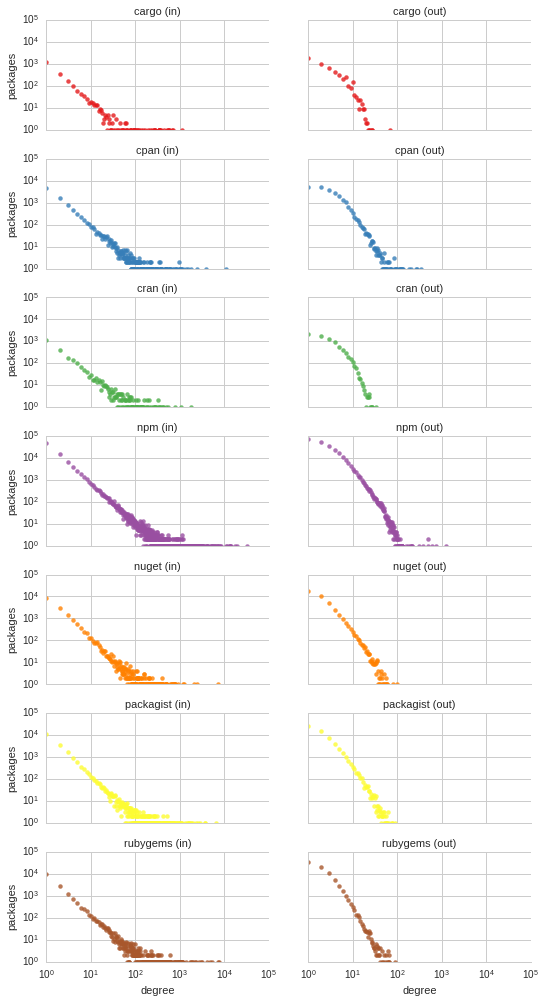

In [27]:
grid = seaborn.lmplot(
    x='degree', 
    y='packages', 
    data=data, 
    hue='ecosystem', 
    col='kind',
    row='ecosystem',
    size=FIG_SIZE[1] / 2,
    aspect=2,
    palette={**COLORS, 'in': 'r', 'out': 'b'},
    fit_reg=False,
)

grid.set_titles('{row_name} ({col_name})')

for ax_line in grid.axes:
    for ax in ax_line:
        ax.set_xscale('log', nonposx='clip')
        ax.set_yscale('log', nonposy='clip')
        ax.set_xlim(10e-1, 10e4)
        ax.set_ylim(10e-1, 10e4)

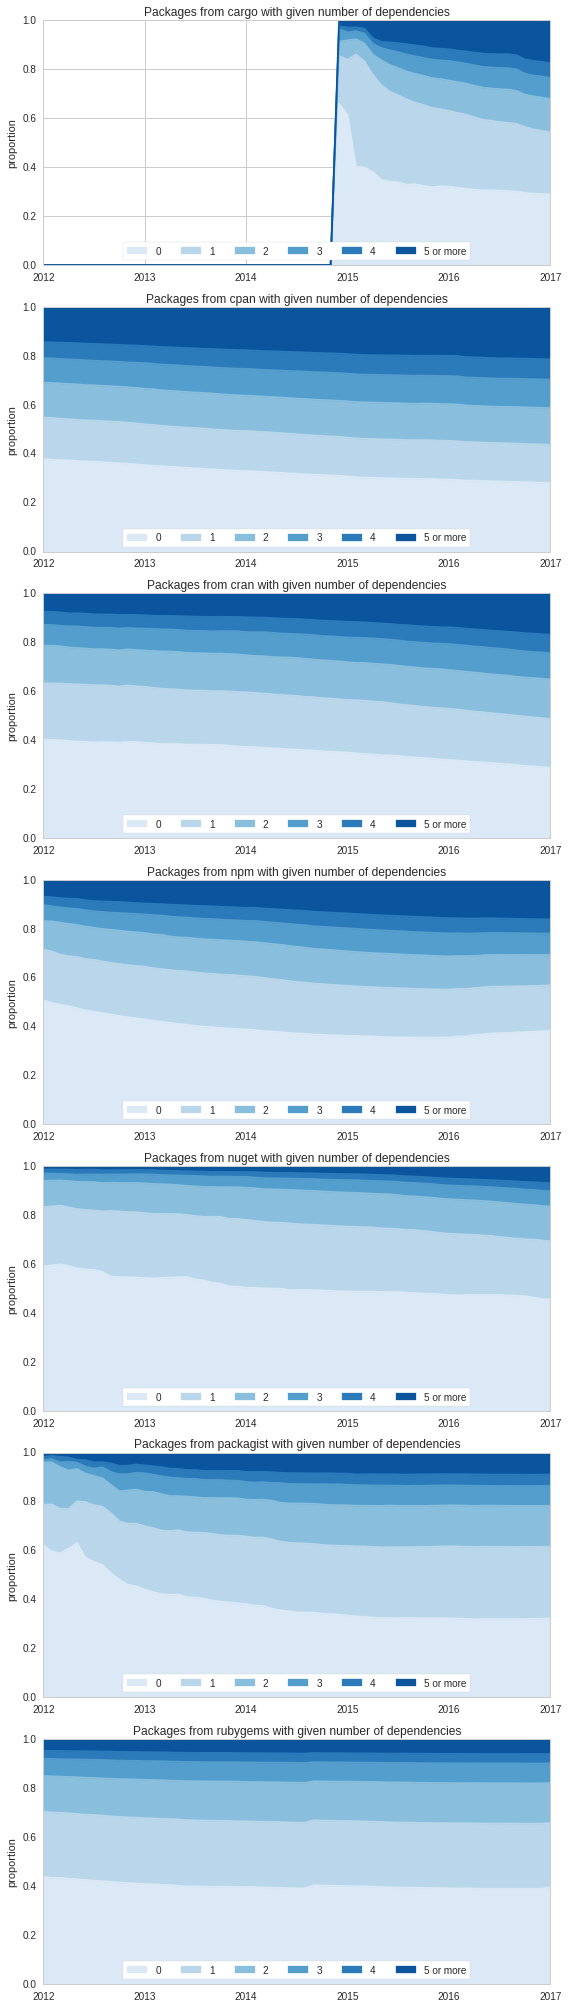

In [28]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))
        
bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5 or more']
                       
for i, (ecosystem, dates) in enumerate(graphs.items()):
    ax = axes[i]
    df = pandas.DataFrame(index=DATE_RANGE, columns=labels)
    
    for date, graph in dates.items():
        counter = collections.Counter(
            pandas.cut(
                graph.vs['out'],
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
        for label in labels: 
            df.loc[date, label] = counter[label] / graph.vcount() if graph.vcount() > 0 else 0
    
    df.plot.area(ax=ax, color=seaborn.color_palette('Blues'))
    
    ax.set(
        xlabel='',
        ylabel='proportion',
        title='Packages from {} with given number of dependencies'.format(ecosystem),
        ylim=(0, 1)
    )
    
    ax.legend(
        ncol=len(labels),
        loc='lower center', 
        frameon=True,
    )

matplotlib.pyplot.tight_layout()

savefig(figure, 'graph_proportion_packages_with_number_of_dependencies')

## Gini index

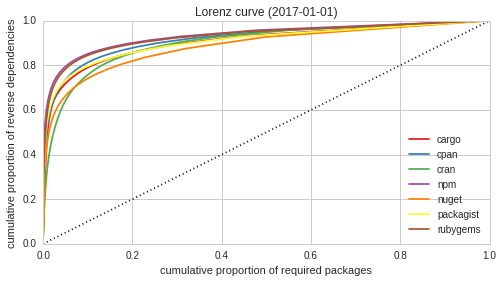

In [29]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

date = DATE_RANGE[-1]

data_temp = []

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    df = (
        pandas.DataFrame(graph.vs['in'], columns=['in'])
        .pipe(lambda d: d[d['in'] > 0])
        .sort_values('in', ascending=False)
        .assign(n=lambda d: 1 / len(d))
        .assign(p=lambda d: d['in'] / d['in'].sum())
        [['n', 'p']]
        .cumsum()
        .set_index('n')
        .rename(columns={'p': ecosystem})
    )
    data_temp.append(df)
    df.plot(ax=ax)


ax.plot([0, 1], [0, 1], 'k:')
    
ax.set(
    title='Lorenz curve ({})'.format(DATE_RANGE[-1].strftime('%Y-%m-%d')),
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel='cumulative proportion of required packages',
    ylabel='cumulative proportion of reverse dependencies',
)

savefig(figure, 'graph_required_lorenz')

In [30]:
for df in data_temp:
    ecosystem = df.columns[0]
    perc = (
        df
        .query('{} >= 0.8'.format(ecosystem))
        .reset_index()
        ['n']
        .iloc[0]
    )
    print('{}: {}'.format(ecosystem, perc))

cargo: 0.11065759637188247
cpan: 0.08856732348111825
cran: 0.1319030591974568
npm: 0.053197503374593356
nuget: 0.16822719662676736
packagist: 0.10421991801302066
rubygems: 0.05960264900662213


In [31]:
data_temp = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        data_temp.loc[date, ecosystem] = len(graph.vs.select(in_gt=0))

data_temp

,cargo,cpan,cran,npm,nuget,packagist,rubygems
2012-01-01,0,5775,925,1299,726,37,4789
2012-02-01,0,5822,939,1469,793,51,4993
2012-03-01,0,5889,958,1644,844,64,5164
2012-04-01,0,5951,982,1838,936,72,5355
2012-05-01,0,6006,995,2037,1030,80,5558
2012-06-01,0,6067,1021,2276,1116,113,5750
2012-07-01,0,6120,1039,2512,1175,160,5910
2012-08-01,0,6239,1060,2752,1311,207,6122
2012-09-01,0,6322,1076,3097,1418,278,6316
2012-10-01,0,6386,1092,3403,1511,368,6477


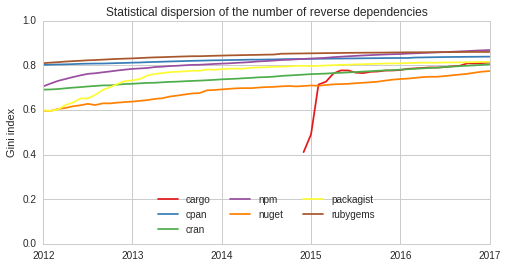

In [32]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        nodes_in = pandas.np.asarray(graph.vs.select(in_gt=0)['in'])
        #data_temp.loc[ecosystem, date] = gini(nodes_in)
        normalised = gini(nodes_in) / (1 - (1/len(nodes_in)))
        data_temp.loc[ecosystem, date] = normalised
    
data_temp = (
    data_temp
    .T
    .sort_index()
)

data_temp.plot(ax=ax)

ax.set(
    title='Statistical dispersion of the number of reverse dependencies',
    xlabel='',
    ylabel='Gini index',
    ylim=(0, 1),
)

ax.legend(loc='lower center', ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_required_gini_index')

In [33]:
pandas.concat([data_temp.min(), data_temp.max(), data_temp.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.410780,0.812388,0.812388
cpan,0.801676,0.838616,0.838616
cran,0.690716,0.804183,0.804183
npm,0.705466,0.868028,0.868028
nuget,0.595607,0.773817,0.773817
packagist,0.595413,0.815029,0.815029
rubygems,0.809266,0.859699,0.859437


In [34]:
evolution_linlog_regressions(data_temp.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.405713,0.965964,0.99877,0.935836,0.974752,0.708354,0.908896
lin-log,0.357354,0.963986,0.997996,0.92072,0.966168,0.679293,0.904912
log-lin,0.854592,0.715315,0.645811,0.82278,0.696906,0.824136,0.792626
log-log,0.84635,0.718369,0.659056,0.840709,0.716848,0.828976,0.796818


## Type of packages

In [35]:
df_connected = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_required = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_dependent = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
            
        connected = graph.vs.select(_degree_gt=0)
        required = graph.vs.select(_indegree_gt=0)
        dependent = graph.vs.select(_outdegree_gt=0)
        
        df_connected.loc[date, ecosystem] = len(connected) / graph.vcount()
        df_required.loc[date, ecosystem] = len(required) / graph.vcount() 
        df_dependent.loc[date, ecosystem] = len(dependent) / graph.vcount()

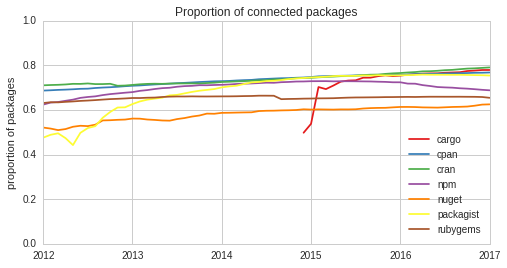

In [36]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_connected.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of packages',
    title='Proportion of connected packages',
    ylim=(0, 1),
)
savefig(figure, 'graph_prop_connected_packages')

In [37]:
pandas.concat([df_connected.min(), df_connected.max(), df_connected.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.497585,0.778736,0.778736
cpan,0.686449,0.767529,0.767529
cran,0.708062,0.790173,0.790173
npm,0.623574,0.728768,0.687715
nuget,0.509383,0.624806,0.624806
packagist,0.442249,0.758043,0.753964
rubygems,0.630682,0.663623,0.654073


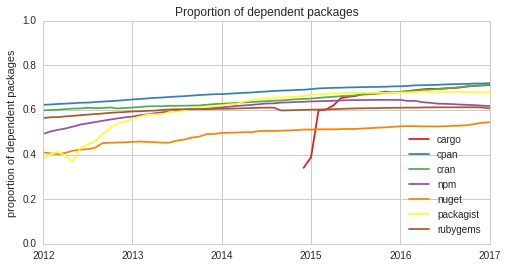

In [38]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_dependent.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of dependent packages',
    title='Proportion of dependent packages',
    ylim=(0, 1),
)
savefig(figure, 'graph_prop_dependent_packages')

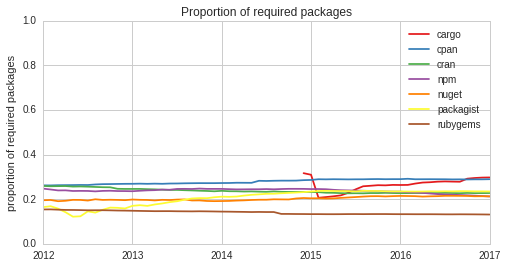

In [39]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_required.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of required packages',
    title='Proportion of required packages',
    ylim=(0, 1),
)
savefig(figure, 'graph_prop_required_packages')

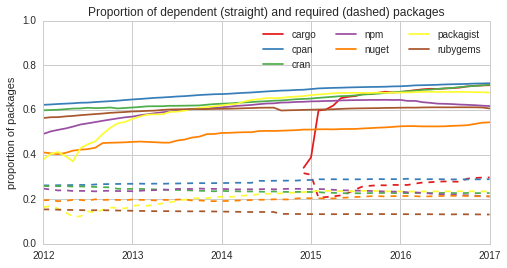

In [40]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_dependent.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
df_required.plot(ax=ax, style='--', legend=False, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of packages',
    title='Proportion of dependent (straight) and required (dashed) packages',
    ylim=(0, 1),
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(ECOSYSTEMS)], labels[:len(ECOSYSTEMS)], ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_prop_required_dependent_packages')

In [41]:
pandas.concat([df_required.min(), df_required.max(), df_required.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.206154,0.316425,0.297265
cpan,0.261604,0.291340,0.289431
cran,0.226079,0.259104,0.227351
npm,0.212109,0.247508,0.212109
nuget,0.190821,0.214966,0.212661
packagist,0.121581,0.237397,0.234486
rubygems,0.131153,0.154178,0.131153


In [42]:
pandas.concat([df_dependent.min(), df_dependent.max(), df_dependent.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.340580,0.710416,0.710416
cpan,0.622569,0.719538,0.719538
cran,0.598039,0.712673,0.712673
npm,0.492015,0.645115,0.617169
nuget,0.401311,0.544316,0.544316
packagist,0.369301,0.681301,0.677855
rubygems,0.563313,0.611619,0.606441


## Isolated packages

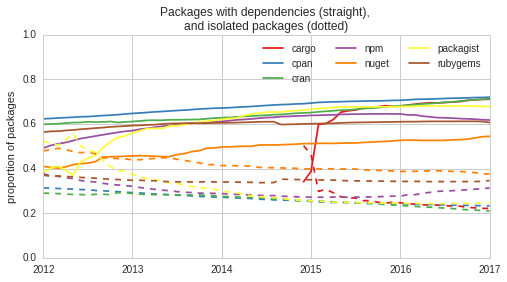

In [43]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2 = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        with_deps = len(list(filter(lambda v: v['out'] > 0, graph.vs)))
        connected = len(list(filter(lambda v: v['in'] + v['out'] > 0, graph.vs)))
        
        try:
            df.loc[date, ecosystem] = with_deps / graph.vcount()
            df2.loc[date, ecosystem] = 1 - (connected / graph.vcount())
        except ZeroDivisionError:
            pass
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
df2.plot(ax=ax, style='--', legend=False, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages',
    title='Packages with dependencies (straight), \nand isolated packages (dotted)',
    ylim=(0, 1),
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(ECOSYSTEMS)], labels[:len(ECOSYSTEMS)], ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_packages_with_dependencies_and_isolated')

In [44]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.492106,0.9804,0.970449,0.698842,0.90477,0.763674,0.684746
lin-log,0.424173,0.975564,0.976501,0.688369,0.885221,0.708271,0.67919
log-lin,0.879754,0.686115,0.518995,0.794699,0.740135,0.798424,0.80181
log-log,0.865745,0.696197,0.532582,0.812314,0.753918,0.806997,0.805842


In [45]:
evolution_linlog_regressions(df2.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.509547,0.97186,0.935591,0.416078,0.89668,0.770979,0.335545
lin-log,0.614423,0.981742,0.922361,0.407581,0.912612,0.83836,0.332518
log-lin,0.887762,0.698484,0.451902,0.662658,0.728777,0.767533,0.602032
log-log,0.899183,0.678113,0.433632,0.632293,0.717579,0.750351,0.593146


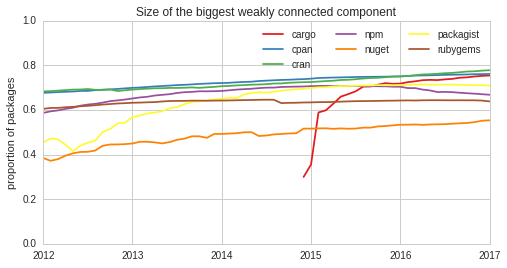

In [46]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        components = graph.components(mode=igraph.WEAK)
        df.loc[date, ecosystem] = components.giant().vcount() / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages',
    title='Size of the biggest weakly connected component',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_size_of_biggest_wcc')

In [47]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.299517,0.753942,0.753942
cpan,0.676429,0.761203,0.761203
cran,0.683193,0.777708,0.777708
npm,0.586312,0.707404,0.667781
nuget,0.371874,0.553225,0.553225
packagist,0.414894,0.714125,0.708849
rubygems,0.604599,0.645605,0.637845


In [48]:
# Proportion of connected packages in WCC
(
    pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)
    /
    pandas.concat([df_connected.min(), df_connected.max(), df_connected.iloc[-1]], axis=1)
)

,0,1,2017-01-01 00:00:00
cargo,0.601942,0.968161,0.968161
cpan,0.985404,0.991759,0.991759
cran,0.964877,0.984225,0.984225
npm,0.940244,0.970685,0.971014
nuget,0.730049,0.885435,0.885435
packagist,0.938144,0.942064,0.940163
rubygems,0.958644,0.972850,0.97519


In [49]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.542222,0.97284,0.961068,0.501672,0.915601,0.806669,0.498802
lin-log,0.451776,0.968383,0.965746,0.502989,0.887146,0.766697,0.497867
log-lin,0.896437,0.69633,0.498653,0.706069,0.76719,0.71826,0.721367
log-log,0.88487,0.704353,0.507917,0.721267,0.789131,0.719547,0.72579


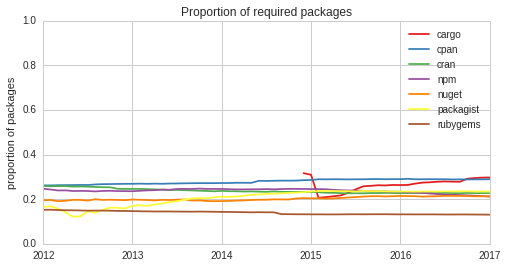

In [50]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        required = len([v for v in graph.vs if v['in'] > 0])
        df.loc[date, ecosystem] = required / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages',
    title='Proportion of required packages',
    ylim=(0, 1),
)

savefig(figure, 'graph_proportion_required_packages')

## Bottom-level packages

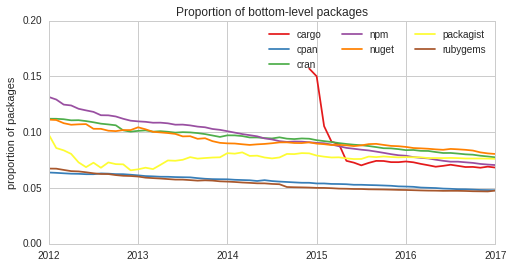

In [51]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_gt=0, out_eq=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages', 
    title='Proportion of bottom-level packages',
    ylim=(0, 0.2)
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_proportion_bottom_level')

In [52]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.428618,0.995401,0.978865,0.986399,0.891107,0.0147085,0.943916
lin-log,0.492341,0.993607,0.980283,0.994342,0.905777,0.0255803,0.958573
log-lin,0.829915,0.605246,0.662431,0.716373,0.747826,0.0785584,0.741072
log-log,0.835471,0.58388,0.629113,0.657422,0.726677,0.0500869,0.713335


## Top-level packages
Top-level packages are packages that are not required but have at least one dependency.

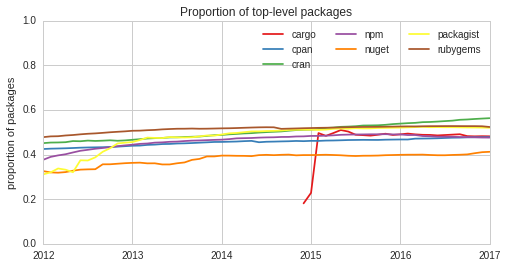

In [53]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_eq=0, out_gt=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages', 
    title='Proportion of top-level packages',
    ylim=(0, 1)
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_proportion_top_level')

In [54]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.181159,0.509674,0.481606
cpan,0.424627,0.478158,0.478158
cran,0.450980,0.562822,0.562822
npm,0.376426,0.491136,0.475756
nuget,0.318562,0.412171,0.412171
packagist,0.311111,0.523901,0.519749
rubygems,0.477878,0.527434,0.523403


In [55]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.172964,0.949648,0.992841,0.709539,0.759347,0.688395,0.779998
lin-log,0.18497,0.944099,0.995422,0.693147,0.746085,0.638876,0.771391
log-lin,0.651192,0.714981,0.575552,0.847989,0.725002,0.825192,0.831151
log-log,0.687387,0.722849,0.592462,0.863804,0.732541,0.829608,0.83551


In [56]:
evolution_linlog_regressions(df[df['cargo'] > 0.3][['cargo']].astype(float))

,cargo
lin-lin,0.349383
lin-log,0.351377
log-lin,0.185520
log-log,0.186483


In [57]:
df_out = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_trout = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_ratio = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

df2_out = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2_trout = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2_ratio = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():    
        if graph.vcount() == 0:
            continue
        vs = graph.vs.select(in_eq=0, out_gt=0)
        out = pandas.Series(vs['out'])
        trout = pandas.Series(vs['tr-out'])
        
        df_out.loc[date, ecosystem] = pandas.np.mean(out)
        df_trout.loc[date, ecosystem] = pandas.np.mean(trout)
        df_ratio.loc[date, ecosystem] = pandas.np.mean(trout / out)
        
        df2_out.loc[date, ecosystem] = pandas.np.median(out)
        df2_trout.loc[date, ecosystem] = pandas.np.median(trout)
        df2_ratio.loc[date, ecosystem] = pandas.np.median(trout / out)

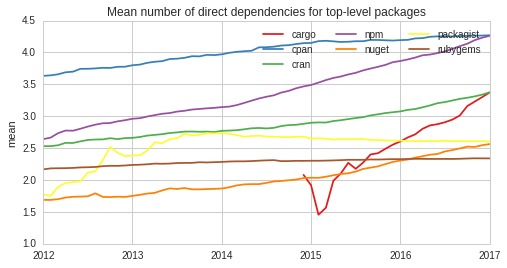

In [58]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_toplevel_mean_direct')

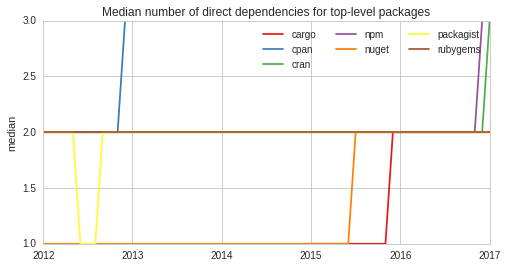

In [59]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Median number of direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_direct')

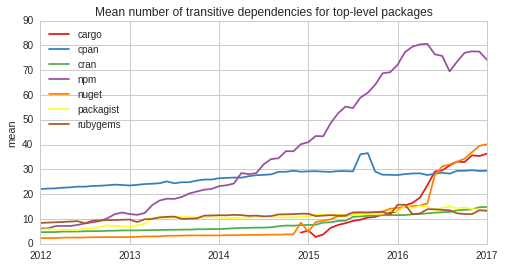

In [60]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_trout.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of transitive dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_transitive')

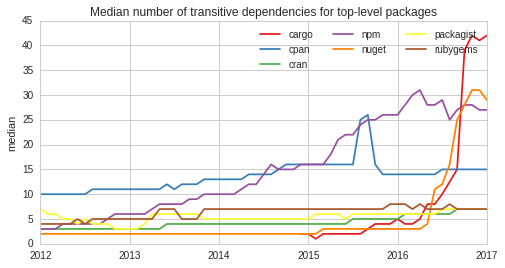

In [61]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_trout.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Median number of transitive dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_transitive')

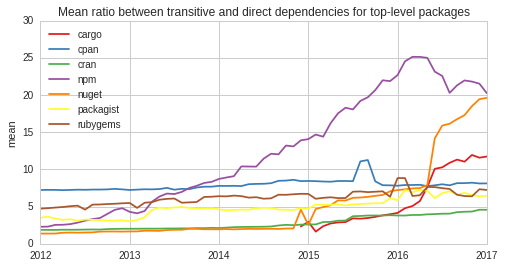

In [62]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_ratio.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean ratio between transitive and direct dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_ratio')

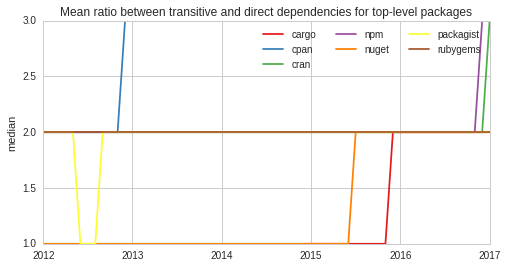

In [63]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Mean ratio between transitive and direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_ratio')

In [64]:
date = DATE_RANGE[-1]

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    vs = graph.vs.select(in_eq=0, out_gt=0)
    data.extend(zip(
        itertools.repeat(ecosystem), 
        vs['out'],
        vs['tr-out']
    ))
            
df = (
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'out', 'tr-out'])
    .assign(ratio=lambda d: d['tr-out'] / d['out'])
    .pipe(lambda d: pandas.melt(d, id_vars='ecosystem', value_vars=['out', 'tr-out', 'ratio'], var_name='kind'))
)

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


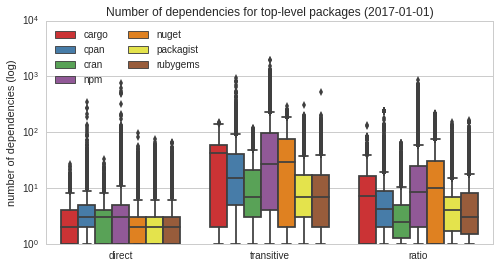

In [65]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=df,
    ax=ax,
    order=['out', 'tr-out', 'ratio'],
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='number of dependencies (log)',
    yscale='log',
    title='Number of dependencies for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['direct', 'transitive', 'ratio'])
ax.legend(loc='upper left', ncol=2)

savefig(figure, 'graph_toplevel_distribution_dependencies')

In [66]:
fig = figure

p_title = figure.suptitle('').get_text()
if len(fig.axes) == 1:
    a_title = fig.axes[0].get_title()
    fig.axes[0].set_title('')
    
# restore
figure.suptitle(p_title)
if len(fig.axes) == 1:
    fig.axes[0].set_title(a_title)


/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


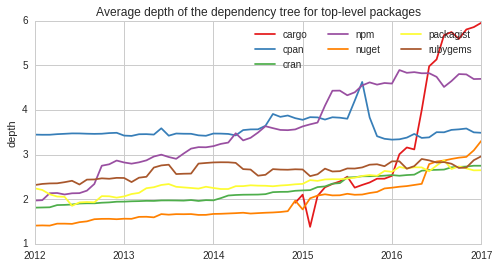

In [67]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        data = []
        for node in graph.vs.select(in_eq=0, out_gt=0):
            m = max((d for v, d, p in graph.bfsiter(node, advanced=True)))
            data.append(m)
        df.loc[date, ecosystem] = pandas.np.mean(data)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='depth', 
    title='Average depth of the dependency tree for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_mean_depth')

In [68]:
date = DATE_RANGE[-1]

bins = [1, 2, 3, 4, 5, 6, pandas.np.inf]
labels = ['1', '2', '3', '4', '5', '6 or more']

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    for node in graph.vs.select(in_eq=0, out_gt=0): 
        depths = []
        for v, d, p in graph.bfsiter(node, advanced=True):
            depths.append(d)
        
        d_max = max(depths)
        d_mean = pandas.np.mean(depths)
        d_median = pandas.np.median(depths)
        
        d_count = collections.Counter(
            pandas.cut(depths, bins=bins, labels=labels, right=False, include_lowest=True)
        )
        
        data.append([ecosystem, d_max, d_mean, d_median] + [d_count[v] for v in labels])

In [69]:
df = pandas.melt(
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'depth', 'mean', 'median'] + labels),
    id_vars='ecosystem',
    value_vars=['depth', 'mean', 'median'] + labels
)

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


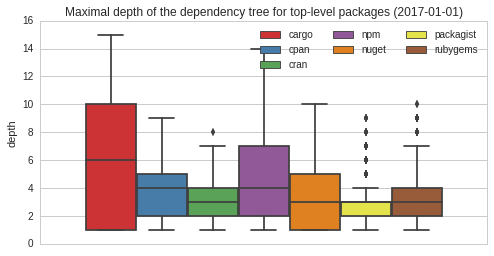

In [70]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='_', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable == "depth"').assign(_=1),
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='depth',
    title='Maximal depth of the dependency tree for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels([''])
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_distribution_depth')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


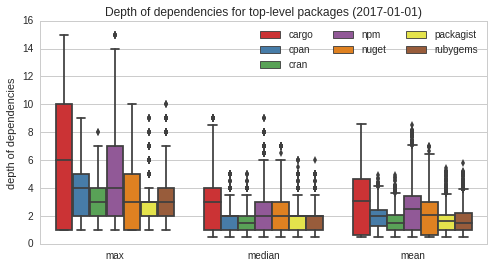

In [71]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable == "depth" or variable == "median" or variable == "mean"'),
    order=['depth', 'median', 'mean'],
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='depth of dependencies',
    title='Depth of dependencies for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['max', 'median', 'mean'])
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_depth_max_median_mean')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


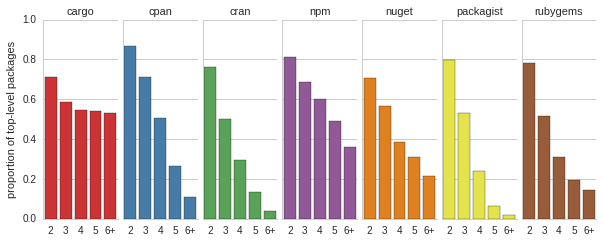

In [72]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable != "depth" and variable != "mean" and variable != "median" and value > 0')
    .groupby(['ecosystem', 'variable'])
    .count()
    .pipe(lambda d: 
        d.apply(lambda r: r / d.loc[(r.name[0], '1'), 'value'], axis=1)
    )
)

grid = (
    seaborn.FacetGrid(
        data=df_tmp.reset_index(),
        col='ecosystem',
        hue='ecosystem',
        hue_order=ECOSYSTEMS, 
        palette=COLORS,
        ylim=(0, 1),
    )
    .map(seaborn.barplot, 'variable', 'value', order=labels[1:])
    .set_titles('{col_name}')
    .set_axis_labels('', 'proportion of top-level packages')
    .set_xticklabels(['2', '3', '4', '5', '6+'])
)
grid.fig.set_size_inches(FIG_SIZE)
grid.fig.suptitle('Top-level packages with at least given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')))

savefig(grid.fig, 'graph_toplevel_proportion_at_least_depth_b')

In [73]:
df_tmp.unstack()

value                                                  
variable      1         2         3         4         5 6 or more
ecosystem                                                        
cargo       1.0  0.713206  0.586458  0.548125  0.540011  0.532177
cpan        1.0  0.866716  0.712999  0.505372  0.265201  0.109496
cran        1.0  0.763762  0.500722  0.296100  0.134649  0.041566
npm         1.0  0.809869  0.685881  0.601311  0.491480  0.362755
nuget       1.0  0.706471  0.566916  0.384136  0.312392  0.212737
packagist   1.0  0.796623  0.529100  0.238076  0.061998  0.019856
rubygems    1.0  0.783507  0.513977  0.308270  0.193671  0.142776

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


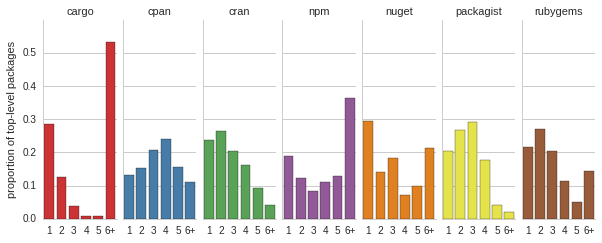

In [74]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable == "depth"')  # Select maximal depth
    .assign(grouped_value=
        lambda d: pandas.cut(d['value'], bins=bins, labels=labels, right=False, include_lowest=True)
    )
    .groupby(['ecosystem', 'grouped_value'])
    .count()
    .pipe(lambda d: 
        d.groupby(level=0).apply(lambda x: x / x.sum())
    )
)

grid = (
    seaborn.FacetGrid(
        data=df_tmp.reset_index(),
        col='ecosystem',
        hue='ecosystem',
        hue_order=ECOSYSTEMS, 
        palette=COLORS,
        ylim=(0, 0.6),
    )
    .map(seaborn.barplot, 'grouped_value', 'value', order=labels)
    .set_titles('{col_name}')
    .set_axis_labels('', 'proportion of top-level packages')
    .set_xticklabels(['1', '2', '3', '4', '5', '6+'])
)
grid.fig.set_size_inches(FIG_SIZE)
grid.fig.suptitle('Top-level packages with given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')))

savefig(grid.fig, 'graph_toplevel_proportion_exact_depth')

In [75]:
df_tmp.unstack()['value']

grouped_value,1,2,3,4,5,6 or more
ecosystem,,,,,,
cargo,0.286794,0.126749,0.038332,0.008114,0.007834,0.532177
cpan,0.133284,0.153717,0.207627,0.240171,0.155705,0.109496
cran,0.236238,0.263040,0.204622,0.161451,0.093083,0.041566
npm,0.190131,0.123988,0.084570,0.109831,0.128725,0.362755
nuget,0.293529,0.139555,0.182780,0.071744,0.099655,0.212737
packagist,0.203377,0.267523,0.291025,0.176077,0.042142,0.019856
rubygems,0.216493,0.269530,0.205707,0.114599,0.050895,0.142776


/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


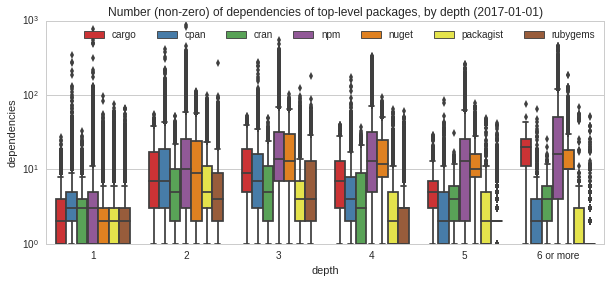

In [76]:
# Number of dependencies by dependency depth

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE_WIDE)

seaborn.boxplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable != "depth" and variable != "mean" and variable != "median" and value > 0'),
    ax=ax,
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='depth', 
    ylabel='dependencies',
    yscale='log',
    title='Number (non-zero) of dependencies of top-level packages, by depth ({})'.format(date.strftime('%Y-%m-%d')),
)    
ax.legend(ncol=len(ECOSYSTEMS))

savefig(figure, 'graph_toplevel_distribution_deps_by_depth')

**TODO**: Which depth should be reached, for a package, to get at least (at most?) x% of all dependencies of this package?

## Examples of packages with lot of "hidden" dependencies

In [77]:
date = DATE_RANGE[-1]

data = []

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    nodes = graph.vs.select(**{'in_gt': graph.vcount() * 0.001, 'tr-out_gt': 30})
    for node in nodes:
        data.append((ecosystem, node['name'], node['in'], node['out'], node['tr-out']))

data = (
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'package', 'in', 'out', 'tr-out'])
    .sort_values(['ecosystem', 'in'], ascending=[True, False])
)

for line in data.itertuples():
    print(' '.join(map(str, line)))

77 cargo serde 576.0 1.0 40.0
64 cargo hyper 563.0 17.0 73.0
60 cargo serde_json 501.0 6.0 46.0
85 cargo clap 368.0 10.0 50.0
68 cargo url 361.0 5.0 51.0
43 cargo regex 344.0 6.0 40.0
78 cargo serde_derive 279.0 1.0 41.0
31 cargo num 268.0 6.0 47.0
10 cargo mime 263.0 3.0 42.0
66 cargo clippy 257.0 1.0 40.0
38 cargo yup-oauth2 232.0 10.0 91.0
12 cargo chrono 186.0 4.0 49.0
25 cargo env_logger 166.0 2.0 40.0
30 cargo docopt 146.0 4.0 42.0
24 cargo toml 132.0 1.0 40.0
80 cargo error-chain 120.0 1.0 46.0
5 cargo yup-hyper-mock 107.0 2.0 74.0
27 cargo serde_macros 94.0 2.0 40.0
15 cargo uuid 91.0 4.0 42.0
62 cargo nom 81.0 2.0 41.0
14 cargo iron 75.0 10.0 80.0
69 cargo mio 73.0 9.0 48.0
36 cargo semver 60.0 1.0 40.0
53 cargo image 54.0 10.0 64.0
22 cargo nalgebra 45.0 7.0 54.0
0 cargo enum_primitive 36.0 1.0 48.0
52 cargo yaml-rust 32.0 2.0 43.0
72 cargo generic-array 31.0 3.0 45.0
70 cargo tokio-core 29.0 5.0 51.0
8 cargo bincode 28.0 4.0 43.0
2 cargo vec_map 25.0 2.0 41.0
6 cargo glium 2

"specific" example

In [103]:
graph = graphs['npm'][DATE_RANGE[-1]]
graph.vs.select(name='react')[0]

igraph.Vertex(<igraph.Graph object at 0x7fea206398b8>, 365263, {'id': 'n365263', 'name': 'react', 'tr-out': 15.0, 'in': 7296.0, 'out': 3.0, 'version': '15.4.1', 'tr-in': 7865.0})

In [78]:
graph = graphs['npm'][DATE_RANGE[-1]]

nodes = graph.vs.select(**{'tr-in_gt': 25000})
candidates= []
for node in nodes:
    depth = []
    for v, d, p in graph.bfsiter(node, mode=igraph.IN, advanced=True):
        if d <= 1:
            continue
        depth.append(d)
    df = pandas.DataFrame(depth).describe()
    
    candidates.append(
        (node['name'], node['in'], node['tr-in'],
         df.loc['mean',0], df.loc['25%', 0], df.loc['50%',0], df.loc['75%',0])
    )

df = pandas.DataFrame.from_records(candidates, columns=['name', 'in', 'tr-in', 'mean', '25%', '50%', '75%'])

In [79]:
df[df['50%'] >= 4].sort_values('in', ascending=False).assign(indin=lambda d: d['tr-in'] - d['in'])

,name,in,tr-in,mean,25%,50%,75%,indin
77,semver,3121.0,63969.0,4.179957,3.0,4.0,5.0,60848.0
25,co,2507.0,53926.0,4.945973,4.0,5.0,6.0,51419.0
130,graceful-fs,907.0,60292.0,4.085291,3.0,4.0,5.0,59385.0
90,hoek,786.0,52600.0,4.198093,3.0,4.0,5.0,51814.0
116,cross-spawn,689.0,38080.0,4.479286,3.0,5.0,6.0,37391.0
109,boom,684.0,50118.0,4.302160,3.0,4.0,5.0,49434.0
134,lru-cache,654.0,41275.0,5.031880,3.0,5.0,7.0,40621.0
119,which,629.0,46921.0,4.846539,3.0,5.0,7.0,46292.0
49,deep-extend,443.0,27229.0,4.729112,3.0,5.0,6.0,26786.0
66,path-exists,430.0,38143.0,5.456792,5.0,6.0,7.0,37713.0


## Relative impact

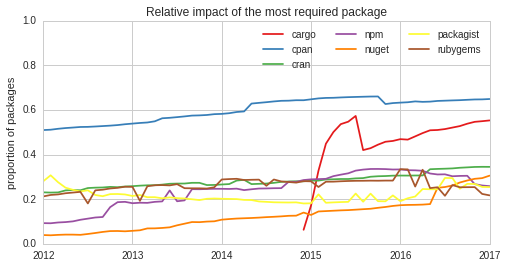

In [80]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = max(graph.vs['tr-in']) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages',
    title='Relative impact of the most required package',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_most_required_relative_impact')

In [81]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.062802,0.572929,0.552756
cpan,0.509589,0.660084,0.64868
cran,0.229544,0.344885,0.344684
npm,0.092023,0.335382,0.258242
nuget,0.038128,0.305366,0.305366
packagist,0.180661,0.306931,0.254066
rubygems,0.180799,0.334239,0.216986


In [82]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.391517,0.83004,0.91466,0.799204,0.899211,0.000383872,0.173556
lin-log,0.302703,0.831217,0.929683,0.744412,0.965881,7.46614e-05,0.17135
log-lin,0.760668,0.631587,0.557543,0.690547,0.472202,0.127544,0.266698
log-log,0.836681,0.647818,0.605263,0.759306,0.665951,0.126227,0.275531


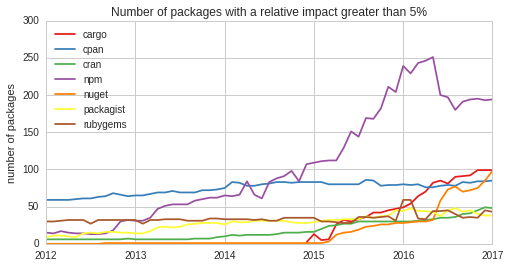

In [83]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 5

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(graph.vs.select(**{'tr-in_ge': p_threshold}))
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='number of packages',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
)

savefig(figure, 'graph_relative_impact_{}'.format(threshold))

In [84]:
print(DATE_RANGE[-1])
graphs['nuget'][DATE_RANGE[-1]].vcount()

2017-01-01 00:00:00


75886

In [85]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,2.0,99.0,99
cpan,59.0,86.0,85
cran,6.0,49.0,48
npm,13.0,251.0,194
nuget,0.0,98.0,98
packagist,9.0,48.0,38
rubygems,27.0,59.0,43


In [86]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.973528,0.725461,0.884984,0.89231,0.617391,0.90709,0.304278
lin-log,0.746287,0.728448,0.941105,0.923746,0.698875,0.856321,0.337933
log-lin,0.600521,0.639334,0.388225,0.468639,0.214385,0.631877,0.141464
log-log,0.849212,0.664971,0.47652,0.663521,0.69442,0.745094,0.162835


In [87]:
for v in evolution_linlog_regressions(df.astype(float), return_raw=True).T.itertuples():
    print(v.Index)
    print(v[1].params[0])

cargo
0.13425079358
cpan
0.01307008772
cran
0.0226445480733
npm
0.130806071757
nuget
0.037623851865
packagist
0.0193249262751
rubygems
0.00619692558435


## Reusability & fragility metrics

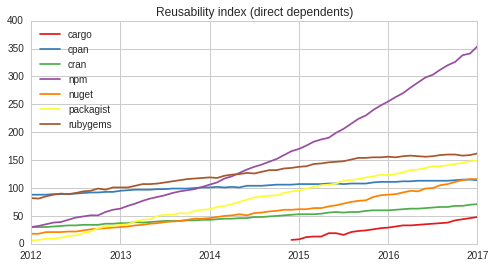

In [88]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (direct dependents)',
)

savefig(figure, 'graph_reusability_index')

In [89]:
evolution_linlog_regressions(df.loc[pandas.to_datetime('2012-01-01'):].astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.984957,0.980056,0.994642,0.966154,0.972557,0.997326,0.982386
lin-log,0.902583,0.970682,0.993962,0.983861,0.985466,0.84757,0.965282
log-lin,0.634115,0.679675,0.593724,0.509015,0.535562,0.634427,0.660917
log-log,0.801125,0.698741,0.664778,0.715634,0.698701,0.844272,0.715221


In [90]:
for v in evolution_linlog_regressions(df.loc[pandas.to_datetime('2012-01-01'):].astype(float), return_raw=True).T.itertuples():
    print(v.Index)
    print(v[1].params[0])

cargo
0.0504197550772
cpan
0.0150170854494
cran
0.0220839418686
npm
0.175077185678
nuget
0.0526276799028
packagist
0.0818931455358
rubygems
0.0465078898809


In [91]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,7.0,48.0,48
cpan,88.0,115.0,114
cran,30.0,71.0,71
npm,30.0,354.0,354
nuget,18.0,116.0,116
packagist,6.0,149.0,149
rubygems,81.0,162.0,162


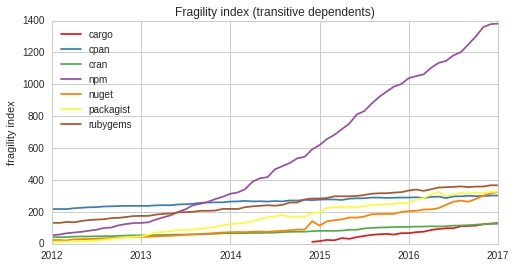

In [92]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['tr-in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='fragility index',
    title='Fragility index (transitive dependents)',
)

savefig(figure, 'graph_fragility_index')

In [93]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,12.0,130.0,130
cpan,218.0,303.0,303
cran,41.0,126.0,126
npm,53.0,1381.0,1381
nuget,21.0,326.0,326
packagist,10.0,327.0,327
rubygems,131.0,367.0,367


In [94]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.989197,0.973191,0.970245,0.957566,0.90895,0.990017,0.993473
lin-log,0.900148,0.962051,0.992875,0.972951,0.987128,0.878079,0.980165
log-lin,0.60384,0.688902,0.532224,0.479152,0.431726,0.583085,0.609436
log-log,0.816733,0.713609,0.629393,0.711048,0.638921,0.800793,0.691127


[(0, 0.05),

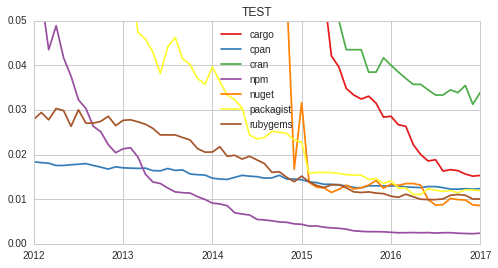

In [95]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = 1 / x_index([n['tr-in'] / n['in'] for n in graph.vs if n['in'] > 0])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='TEST',
    ylim=(0, 0.05)
)

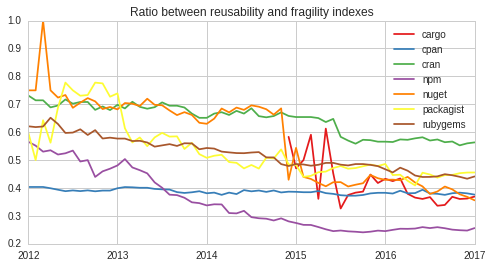

In [96]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['in']) / x_index(graph.vs['tr-in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio between reusability and fragility indexes',
)

savefig(figure, 'graph_reuse_over_fragility')

In [97]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.326531,0.612903,0.369231
cpan,0.372414,0.403670,0.376238
cran,0.552846,0.731707,0.563492
npm,0.241090,0.566038,0.256336
nuget,0.355828,1.000000,0.355828
packagist,0.409231,0.777778,0.455657
rubygems,0.433243,0.651852,0.441417


In [98]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.443297,0.505205,0.859972,0.86655,0.820804,0.649838,0.963128
lin-log,0.449196,0.504743,0.850077,0.896723,0.829174,0.696458,0.969768
log-lin,0.458892,0.438379,0.471498,0.706313,0.461776,0.342232,0.646453
log-log,0.446682,0.4345,0.451923,0.663235,0.433586,0.366311,0.621293


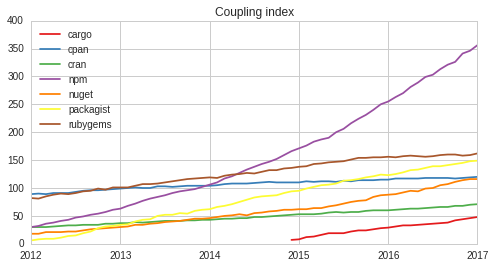

In [99]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['in'] + graph.vs['out'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Coupling index',
)

## Stability metric

In [100]:
data = []

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        s0 = s3 = s7 = sU = 0
        for node in graph.vs: 
            try: 
                s = node['out'] / (node['out'] + node['in'])
                if 0 <= s <= 0.3:
                    s0 += 1
                elif s <= 0.7:
                    s3 += 1
                else:
                    s7 += 1
            except ZeroDivisionError as e: 
                sU += 1
        T = s0 + s3 + s7 + sU + 0.00000000000000000000000001
        data.append((ecosystem, date, '0', s0 / T))
        data.append((ecosystem, date, '3', s3 / T))
        data.append((ecosystem, date, '7', s7 / T))
        data.append((ecosystem, date, 'U', sU / T))

df = pandas.DataFrame.from_records(data, columns=['ecosystem', 'date', 'kind', 'value'])

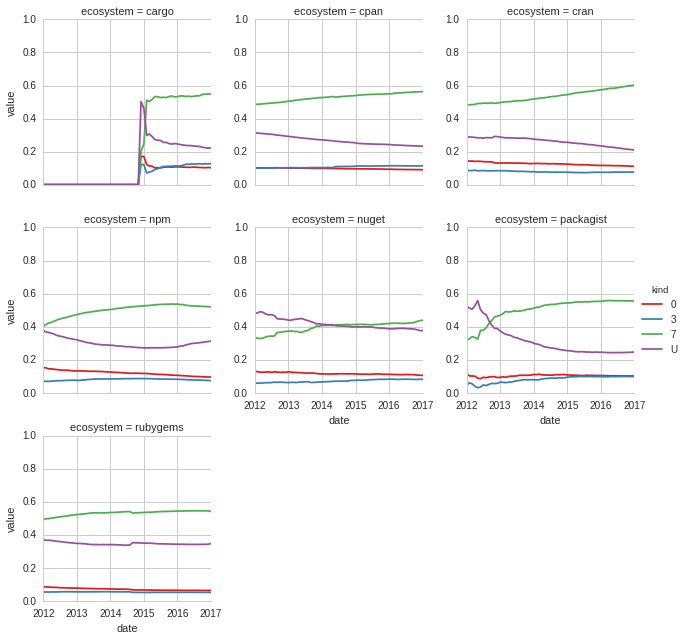

In [101]:
g = seaborn.FacetGrid(
    data=df, 
    col='ecosystem',
    hue='kind',
    sharex=True,
    sharey=False,
    row_order=ECOSYSTEMS,
    col_wrap=3,
)

g.map(matplotlib.pyplot.plot, 'date', 'value')
g.set(ylim=(0, 1))
g.add_legend()

 